# Forecasting climate change project

Managing climate change is one of the big challenges of our time. In the 2015 Paris climate agreement countries committed themselves to keep long-term average temperature rises within 1.5 degrees Celsius compared to pre-industrialised levels. However, [current forecasts](https://www.reuters.com/business/environment/climate-nears-point-no-return-land-sea-temperatures-break-records-experts-2023-06-30/) predict that this benchmark will already be reached with a 66% likelihood between now and 2027. One main contributor to climate change is the emission of greenhouse gases. [Greenhouse gases](https://scied.ucar.edu/learning-zone/how-climate-works/some-greenhouse-gases-are-stronger-others) (including CO<sub>2</sub>, methane and nitrous oxides) trap solar energy in the earth's atmosphere leading to rising temperatures (called the [greenhouse effect](https://scied.ucar.edu/learning-zone/how-climate-works/greenhouse-effect)). In this project I will employ statistical machine learning methods to try to forecast global greenhouse gas emissions and identify the most prominent predictors. Such a forecast can provide valuable insights to guide decision-making by policy-makers.

## Data

For this project I will be using data retrieved from the world bank database. My main outcome measure of interest will be yearly total greenhouse gas emissions (kt of CO2 equivalent) world-wide included in the dataset on the topic ["climate change"](https://data.worldbank.org/topic/19). Data for this measure are available for the time-period between 1990 and 2019. Other features included in this dataset are demographic (e.g., urban population, poverty levels, education), environmental (e.g., protected areas, forest areas, extreme wheather events) and economic indicators (e.g., (renewable) energy use, investments, agricultural production). I will merge this dataset with another dataset from the world bank database with the topical tag ["infrastructure"](https://data.worldbank.org/topic/9). This will allow me to include additional economic indicators that appear relevant in predicting greenhouse gas emissions, such as the transport of passenger and goods via air, water and rail networks.

To visualise trends in greenhouse gas emissions for this time period, I will also prepare the data with respect to each country. However, for my forecast models I will only focus on features for the region labeled World (WLD).

### Data preparation

In [1]:
# import libraries
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import seaborn as sns
#import sklearn

np.random.seed(3123) # set random seed for reproducibility

I first merge the two datasets and remove duplicate features present in both datasets (these features were categorized as belonging to both the "climate change" and the "infrastructure" topics in the world bank repository).

> NB: The datasets are stored in two csv files included in the base directory

In [2]:
df1 = pd.read_csv('./climate_change.csv',header=2)
df2 = pd.read_csv('./infrastructure.csv',header=2)

print(df1.shape)

for idc in df2["Indicator Code"].unique():
    df1.drop(df1[df1["Indicator Code"].eq(idc)].index, inplace=True)

print(df1.shape)

df = pd.DataFrame(np.concatenate((df1,df2),axis=0),columns=df1.columns)
df = df.drop(df.columns[-1],axis=1) # drop unnamed column with nans


(20216, 68)
(18088, 68)


Reformat dataframe for visualisations and modelling: Columns are features labeled by the indicator code. One column is the categorical variable with the country/region code. Rows are observations labeled by year (i.e., each country has a labeled row for each year).

In [3]:
df_adj = pd.DataFrame(None,columns= df["Indicator Code"].unique())
df_adj.insert(0,"Country Code",None)
df_adj.insert(0,"Country Name",None)
df_adj.insert(0,"Year",None)

for c in df["Country Code"].unique():

    df_c = df[df["Country Code"].eq(c)]
    df_c = df_c.drop(["Country Name","Country Code","Indicator Name"],axis=1)
    df_c = pd.DataFrame(np.array(df_c.iloc[:,1:]).transpose(),columns=df_c["Indicator Code"],index=df_c.columns[1:])
    df_c.insert(0,"Country Code",np.repeat(c,df_c.shape[0],axis=0))
    df_c.insert(0,"Country Name",np.repeat(df[df["Country Code"] == c]["Country Name"].iloc[0],df_c.shape[0],axis=0))
    df_c.insert(0,"Year",df_c.index)


    df_adj = pd.DataFrame(np.concatenate((df_adj,df_c),axis=0),columns=df_adj.columns)
    del df_c

df_adj.rename(index=df_adj["Year"],inplace=True)
df_adj = df_adj.drop("Year",axis=1)

Create two dataframes:
* one dataframe for country/region-wise visualisation only including the total greenhouse gas emissions indicator
* one dataframe for modelling including all features for the region "World" (WLD)

In [4]:
# create by country data frame for visulisation
df_emiss = df_adj[["Country Code", "Country Name", "EN.ATM.GHGT.KT.CE"]]
# create world data frame for analysis
df_world = df_adj.loc[df_adj["Country Code"].eq("WLD")]
df_world = df_world.drop(["Country Code", "Country Name"],axis=1)

# drop features which are a function of the greenhouse gas emissions indicator (e.g. measures of specific greenhouse gases and transformations)
df_world = df_world.drop(["EN.ATM.SF6G.KT.CE", "EN.ATM.PFCG.KT.CE", "EN.ATM.NOXE.ZG", "EN.ATM.NOXE.KT.CE", "EN.ATM.METH.ZG", "EN.ATM.METH.KT.CE", "EN.ATM.HFCG.KT.CE", "EN.ATM.GHGT.ZG", "EN.ATM.GHGO.ZG", "EN.ATM.GHGO.KT.CE", "EN.ATM.CO2E.SF.ZS", "EN.ATM.CO2E.SF.KT", "EN.ATM.CO2E.PP.GD.KD", "EN.ATM.CO2E.PP.GD", "EN.ATM.CO2E.PC", "EN.ATM.CO2E.LF.ZS", "EN.ATM.CO2E.LF.KT", "EN.ATM.CO2E.KT", "EN.ATM.CO2E.KD.GD", "EN.ATM.CO2E.GF.ZS", "EN.ATM.CO2E.GF.KT", "EN.ATM.CO2E.EG.ZS"],axis=1)


### Data cleaning

I will remove data for years where no greenhouse gas emission data is available for the World region (beginnig and end of the time-series). This subsets the data to the time period between 1990 and 2019. We will apply the same subset for the country-wise dataframe (also dropping countries entirely if no data is available).

In [5]:
# deal with nans (for analysis and plotting separately)
nan_idx = df_world.index[df_world["EN.ATM.GHGT.KT.CE"].isna()]
df_world = df_world.drop(nan_idx,axis=0)
df_emiss = df_emiss.drop(nan_idx,axis=0) # also apply to country df

# drop countries with missing values (for plotting)
def check_na(x):
    return x.isna().any()

miss_c = df_emiss.groupby(by="Country Code").agg(check_na)


incl_idx=np.array(df_emiss["Country Code"].map(lambda x: x not in miss_c.index[miss_c["EN.ATM.GHGT.KT.CE"]]))

df_emiss = df_emiss.loc[incl_idx]
del incl_idx, miss_c

# add column to express change as % from 1990
df_emiss_change = df_emiss.groupby(by="Country Code")["EN.ATM.GHGT.KT.CE"].apply(lambda x: (x / x.iloc[0])*100)
df_emiss_change.index = df_emiss.index

df_emiss["EN.ATM.GHGT.KT.CE_perc"] = df_emiss_change

# change dtype to numeric
df_emiss["EN.ATM.GHGT.KT.CE"] = pd.to_numeric(df_emiss["EN.ATM.GHGT.KT.CE"])
df_emiss["EN.ATM.GHGT.KT.CE_perc"] = pd.to_numeric(df_emiss["EN.ATM.GHGT.KT.CE_perc"])


Next, I remove from the world dataframe all features with more than 75% missing values. I will deal with the remaining missing values in the feature engineering step.

In [6]:
print((df_world.isna().mean() > 0.75).sum())

df_world.dropna(axis=1,thresh=np.round(df_world.shape[0]*0.75),inplace=True)

print((df_world.isna().sum() > 0).sum())

34
16


I will deal with the remaining missing datapoints in the feature engineering step.

## Visualizations

Create an interactive dashboard that lets you explore greenhouse gas emissions since 1990 for different countries and inspect the time-courses of other economic indicators used to forecast world-wide greenhouse gas emissions in this project.

In [39]:
from dash import Dash, html, dash_table, dcc, Input, Output, callback
import plotly.express as px

#---define some variables helpful for plotting---

# year index
year = pd.to_numeric(df_emiss.index.unique().tolist())

# country code mapping
country_list = df_emiss["Country Name"].copy()
country_list.index=df_emiss["Country Code"]
country_list.drop_duplicates(keep='first',inplace=True)
country_list = country_list.to_dict()

# indicator key mapping
indicator_dict = df[df["Country Code"] == 'WLD'][["Indicator Code", "Indicator Name"]].copy()
indicator_dict.index=df[df["Country Code"] == 'WLD']["Indicator Code"]
indicator_dict = indicator_dict.loc[df_world.columns]
indicator_dict = indicator_dict.to_dict('records')

#---Configure the app---
app = Dash()

# create choropleth map object
fig_worldMap = px.choropleth(df_emiss, locations='Country Code', color="EN.ATM.GHGT.KT.CE_perc", hover_name='Country Name', range_color=[min(df_emiss["EN.ATM.GHGT.KT.CE_perc"]), np.mean(df_emiss["EN.ATM.GHGT.KT.CE_perc"])+np.std(df_emiss["EN.ATM.GHGT.KT.CE_perc"])],
                    projection='natural earth', animation_frame=df_emiss.index, labels = {'EN.ATM.GHGT.KT.CE_perc': 'GHG%', 'index': 'year'})

app.layout = html.Div(style={'font-family': 'arial', 'max-width': '95%', 'margin': 'auto'}, children=[

    # title and info text
    html.H1(children="🌎 Climate Change", style={'textAlign': 'center'}),
    dcc.Markdown('''
                This dashboard allows you to explore the development of greenhouse gas (GHG) emissions of different countries and indicators used to forecast changes in worldwide GHG emissions in [this project](https://github.com/AlexSkowron/climate_change_forecasting).
                '''),
    html.Br(),

    # greenhouse gas emissions by country plots
    html.Div([
        html.Div([
            "World-wide greenhouse gas emissions as % change from 1990 (GHG%)",
            dcc.Graph(figure=fig_worldMap)
        ], style={'width': '60%', 'display': 'inline-block', 'vertical-align': 'top'}),
        html.Div([
            "Select countries from the drop-down menu:",
            dcc.Dropdown(id = 'country_select', options=country_list, value=['WLD'], multi=True),
            dcc.Graph(id = 'countryGHG_fig'),
            html.Br()
        ], style={'width': '35%', 'display': 'inline-block', 'padding-left': '4%'})
    ]),

    # indicator plots
    html.Div([
        html.Div([
            "Select forecast indicator from the drop-down menu:",
            dcc.Dropdown(id = 'indicator_select', options=df_world.columns, value='EN.ATM.GHGT.KT.CE'),
            dcc.Graph(id = 'indicator_fig')
        ], style={'width': '50%', 'display': 'inline-block', 'vertical-align': 'top'}),
        html.Div([
            dash_table.DataTable(data=indicator_dict, page_size=14, style_cell={'textAlign': 'left', 'font-family':'arial', 'font-size': 12}),
        ], style={'width': '40%', 'display': 'inline-block', 'padding-left': '4%'})
    ], style={'padding-top': 60}),
])
@callback(
    Output('countryGHG_fig', 'figure'),
    Input('country_select', 'value')
)
def update_figure(selected_country):

    df_plot = pd.DataFrame(None,columns=selected_country)

    for c in selected_country:
        df_plot[c] = df_emiss[df_emiss["Country Code"] == c]['EN.ATM.GHGT.KT.CE']

    fig_countryGHG = px.line(df_plot, x=year, y=selected_country, labels={'x': 'year', 'value': 'Total greenhouse gas emissions<br>(kt of CO2 equivalent)', 'variable': 'country'})

    return fig_countryGHG
@callback(
    Output('indicator_fig', 'figure'),
    Input('indicator_select', 'value')
)
def update_figure(selected_indicator):

    fig_indicator = px.line(df_world, x=pd.to_numeric(df_world.index.to_list()), y=selected_indicator, labels={'x': 'year'})

    return fig_indicator


# Run the app
if __name__ == '__main__':
    app.run(jupyter_mode="tab",port=8060)

Dash app running on http://127.0.0.1:8060/


<IPython.core.display.Javascript object>

## Feature engineering

The visualisations revealed non-stationarity in many features. I will therefore start by transforming the features. For simplicity, I will apply the same transformation to each feature. I transform the data by calculating the second difference (this seemed to get rid of most visible non-stationarity after some quick testing). I will also log transform the features to mitigate the effect of outliers.

> NB: All preprocessing steps should be based on the training set and applied to the test set. For this exercise, I will simply perform all feature engineering steps on all datapoints.

In [7]:
import sklearn.preprocessing

print(df_world.min().min()) # check that no column has negative values

df_world_tf = df_world.copy()

# function to compute log ignoring nans
def log_ignoreNull(ARR):

    return [np.log(x) if x != None else x for x in ARR]

df_world_tf = df_world_tf.apply(log_ignoreNull).diff().diff() # this transformation seems to do a good job. For simplicity I omit more nuanced treatments.
df_world_tf = df_world_tf.iloc[2:] # first two rows lost by using diff


0.0488246930836708


Next, I will deal with the remaining missing values by imputing them with the mean of each feature.

In [8]:
print((df_world_tf.isna().sum() > 0).sum())
df_world_tf.fillna(df_world_tf.mean(),inplace=True)
print((df_world_tf.isna().sum() > 0).sum())

16
0


Lastly, I will normalise the data in preparation for modelling.

In [9]:
sklearn.preprocessing.scale(df_world_tf, copy=False)

array([[-3.53580566e-01, -1.11681128e+00, -4.33503084e-01, ...,
        -6.84123668e-01,  4.30483292e-01,  1.96648417e-17],
       [-5.04338353e-01, -1.04968672e+00,  4.29308855e-02, ...,
         1.79282437e+00, -4.18163132e-01,  1.96648417e-17],
       [ 5.72788343e-02, -4.45316763e-01,  5.03020092e-01, ...,
        -1.93174997e+00,  3.14003528e-01,  1.96648417e-17],
       ...,
       [-4.73925015e-01, -4.79397719e-01, -2.03278229e-01, ...,
         0.00000000e+00,  2.16409088e-17, -6.60930207e-01],
       [-3.59517335e-01, -9.21254013e-01, -4.53480731e-01, ...,
         0.00000000e+00,  2.16409088e-17,  7.79914219e-01],
       [-4.03900293e-01, -9.59228427e-01, -6.49921145e-02, ...,
         0.00000000e+00,  2.16409088e-17,  2.12370342e-01]])

A final look at the transformed features that will enter into our models.

<Axes: >

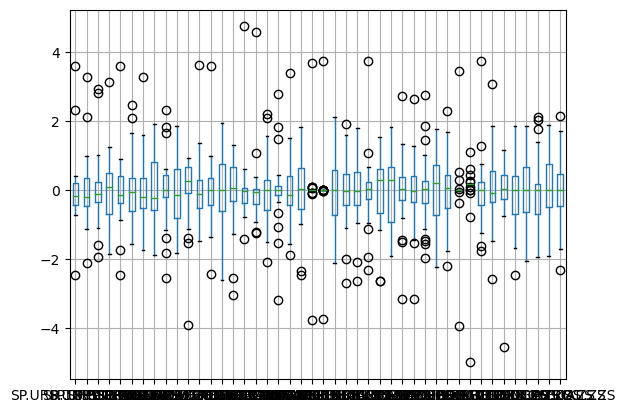

In [10]:
df_world_tf.boxplot()

In [11]:
df_world_tf.describe()

,SP.URB.TOTL.IN.ZS,SP.URB.TOTL,SP.URB.GROW,SP.POP.TOTL,SP.POP.GROW,SI.POV.DDAY,SH.DYN.MORT,SE.PRM.CMPT.ZS,SE.ENR.PRSC.FM.ZS,NV.AGR.TOTL.ZS,...,ER.H2O.INTR.PC,ER.H2O.INTR.K3,EG.USE.ELEC.KH.PC,EG.ELC.PETR.ZS,EG.ELC.NUCL.ZS,EG.ELC.NGAS.ZS,EG.ELC.LOSS.ZS,EG.ELC.HYRO.ZS,EG.ELC.COAL.ZS,BX.GSR.CCIS.ZS
count,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,...,2.800000e+01,2.800000e+01,2.800000e+01,28.000000,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01,2.800000e+01
mean,-3.965082e-17,2.379049e-17,-5.253734e-17,-1.586033e-17,1.586033e-17,1.982541e-17,1.784287e-17,-2.478176e-19,-7.930164e-18,-2.379049e-17,...,-6.567167e-18,5.749369e-17,-2.176560e-18,0.000000,-2.379049e-17,-2.070726e-17,3.098866e-17,-7.930164e-18,1.895189e-17,5.253734e-17
std,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,...,1.018350e+00,1.018350e+00,1.018350e+00,1.018350,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00,1.018350e+00
min,-2.461775e+00,-2.105152e+00,-1.931642e+00,-1.844948e+00,-2.463806e+00,-1.568040e+00,-1.741536e+00,-1.867929e+00,-2.527843e+00,-1.809567e+00,...,-3.934448e+00,-4.988644e+00,-1.762573e+00,-2.573223,-4.538706e+00,-2.441798e+00,-2.055608e+00,-1.931750e+00,-1.912899e+00,-2.298840e+00
25%,-4.296309e-01,-4.538370e-01,-3.444068e-01,-6.826322e-01,-3.666979e-01,-5.852623e-01,-5.099013e-01,-5.574301e-01,-2.010393e-01,-7.971184e-01,...,-5.594412e-03,1.537306e-01,-4.254318e-01,-0.334432,-2.411283e-01,-6.850848e-01,-6.290617e-01,-6.717062e-01,-4.798383e-01,-4.488423e-01
50%,-1.659935e-01,-1.780143e-01,-1.007292e-01,9.588032e-02,-1.444132e-01,-5.812981e-02,-1.948082e-01,-2.161412e-01,1.858218e-02,-1.313089e-01,...,-1.258924e-03,1.819747e-01,-1.358130e-18,-0.082493,3.475345e-02,1.418345e-02,2.263162e-17,0.000000e+00,2.164091e-17,1.966484e-17
75%,2.133992e-01,3.672768e-01,2.411850e-01,4.980009e-01,4.113876e-01,3.458324e-01,3.540151e-01,8.256919e-01,4.529325e-01,6.145928e-01,...,8.584624e-03,1.819747e-01,2.336034e-01,0.565752,4.578969e-01,4.126150e-01,6.638937e-01,1.984160e-01,7.691380e-01,4.856401e-01
max,3.601836e+00,3.294843e+00,2.946700e+00,3.151222e+00,3.600427e+00,2.486749e+00,3.275915e+00,1.923542e+00,2.328452e+00,1.862355e+00,...,3.466233e+00,1.122986e+00,3.746048e+00,3.080894,1.179752e+00,1.865712e+00,1.856905e+00,2.140510e+00,1.903832e+00,2.146458e+00


The data now look normalised (although I'm unsure if the presence of outliers may present a problem).

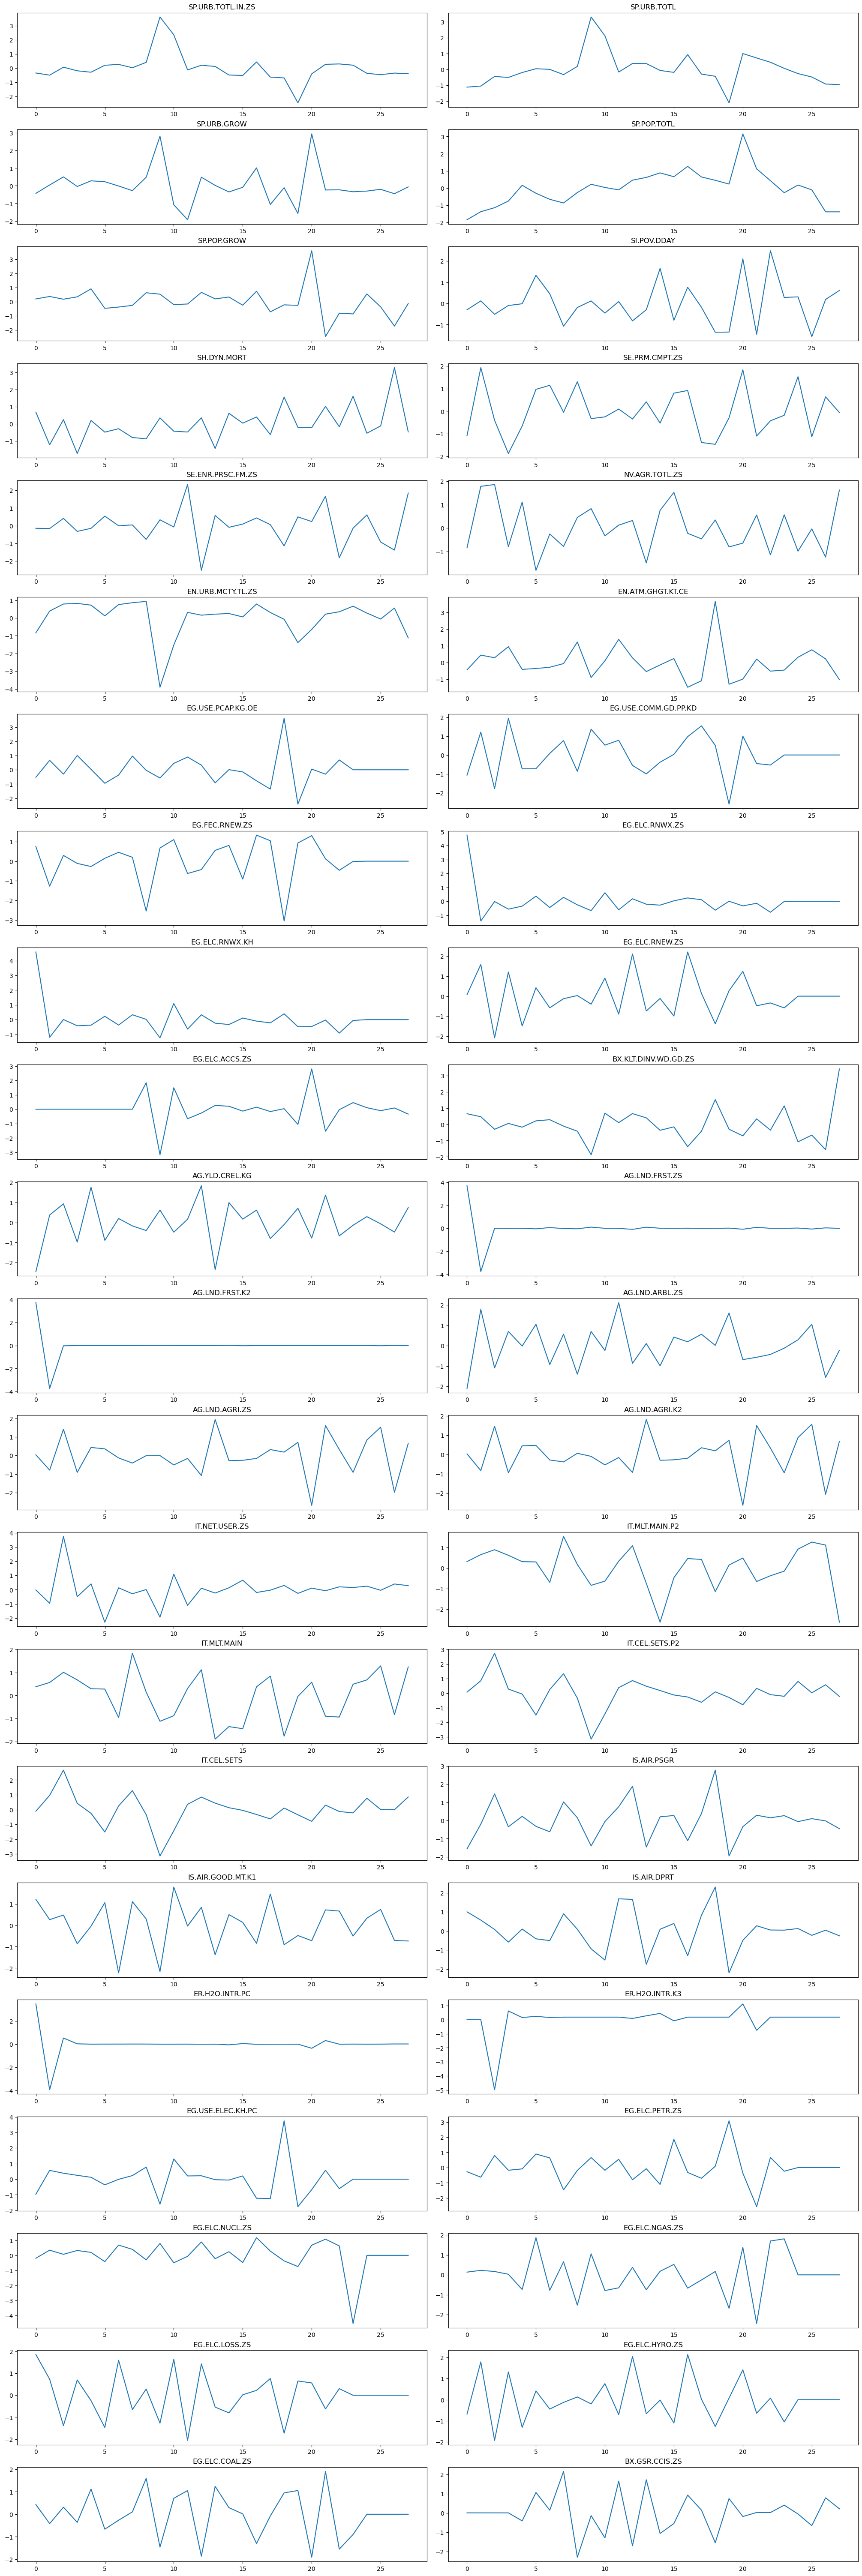

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=22, figsize=(20,60),layout="constrained")

col_idx = -1
for x_idx  in range(22):
    for y_idx in range(2):
        col_idx += 1

        if col_idx >= df_world_tf.shape[1]:
            continue

        axs[x_idx, y_idx].plot(np.arange(df_world_tf.shape[0]), df_world_tf[df_world_tf.columns[col_idx]])
        axs[x_idx, y_idx].set_title(df_world_tf.columns[col_idx])

plt.show()

The transformations seem to have removed much of the non-stationary behavior of the features.

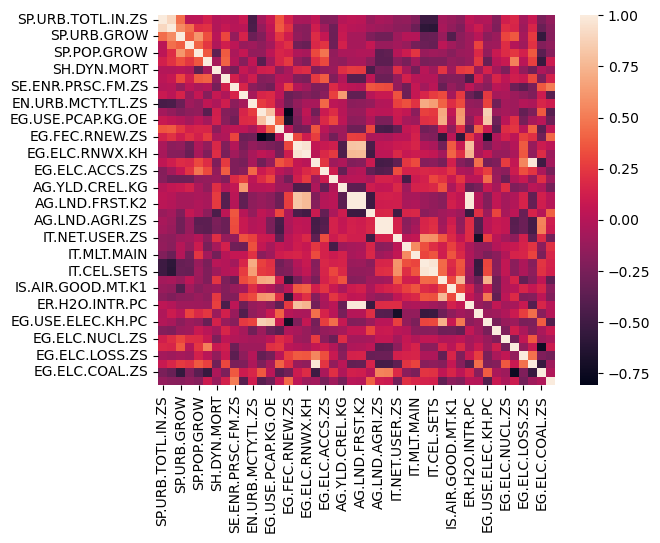

In [13]:
sns.heatmap(df_world_tf.corr())

plt.show()

We see some colinearity between features. This is to be expected since different economic and demographic features probably cluster together.

## Methods and Results

My aim is to forecast total greenhouse gas emissions world-wide from the features included in the final dataset. With 28 timepoints and 44 features we have p > n so penalized regression or non-linear machine learning methods should be appropriate for this problem.

First, I will split the dataset into a training set (for model fitting) and a test set (to evalute forecast predictions). The training set will include the time-period from 1992 to 2014 (note that we lost two timepoints because of the data transformation) and the test set from 2015 to 2019. Because I am trying to forecast, I will predict greenhouse gas emissions at time t+1 from features at time t.

In [28]:
# define train and test data
IS = df_world_tf.index < '2015'
dt_train = df_world_tf.loc[IS,:]
dt_test  = df_world_tf.loc[~IS,:]

# forecast t+1
y_train = dt_train["EN.ATM.GHGT.KT.CE"][1:]
X_train = dt_train.iloc[:-1,:]

y_test = dt_test["EN.ATM.GHGT.KT.CE"][1:]
X_test = dt_test.iloc[:-1,:]

print(X_train.index[0], y_train.index[0])
print(X_test.index[0], y_test.index[0])


1992 1993
2015 2016


I will compare the out-of-sample performance of different linear and non-linear models in forecasting total greenhouse gas emissions. As benchmarks, I will also include a naive forecaster (prediction only based on the mean of y in the training set) and a full model (prediction based on all features).

First, I will set up all models that I want to compare and tune their parameters (where necessary). Furthermore, I will look at the most important predictors identified by the models if the model can provide such insight.

### Naive model

In [ ]:
def naive_forecaster(y_train):
  return np.mean(y_train)

### Full model

In [ ]:
from sklearn.linear_model import LinearRegression

def full_model(y_train, x_train, x_test):
  reg  = LinearRegression( fit_intercept=True ) # We create an instance of the linear regression class.
  reg.fit( X = x_train, y = y_train )
  return reg.predict(x_test)

### LASSO model

Setting up the model, tuning its parameter and looking at the important features for prediction.

0.24343688735431118


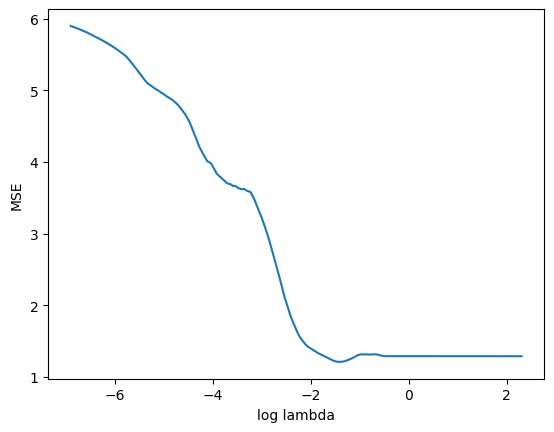

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(fit_intercept = True, max_iter=1000000, cv=X_train.shape[0], alphas = np.exp(np.linspace(np.log(0.001), np.log(10),1000)))
lasso.fit(X=X_train, y=y_train)

print(lasso.alpha_)
plt.plot(np.log(lasso.alphas_), lasso.mse_path_.mean(axis=1))
plt.xlabel("log lambda")
plt.ylabel("MSE")
plt.show()

In [ ]:
print( np.abs(lasso.coef_ > 0).sum())

print(X_train.columns[(np.abs(lasso.coef_) > 0)])

3
Index(['EG.USE.COMM.GD.PP.KD', 'EG.FEC.RNEW.ZS', 'IS.AIR.GOOD.MT.K1'], dtype='object')


The fitted LASSO model chooses a lambda parameter of 0.24 and selects three predictors: Energy use (kg of oil equivalent) per $1,000 GDP, renewable energy consumption, and freight air transport (million ton-km).

### ELASTIC Net model

Setting up the model, tuning its parameters and looking at the important features for prediction.

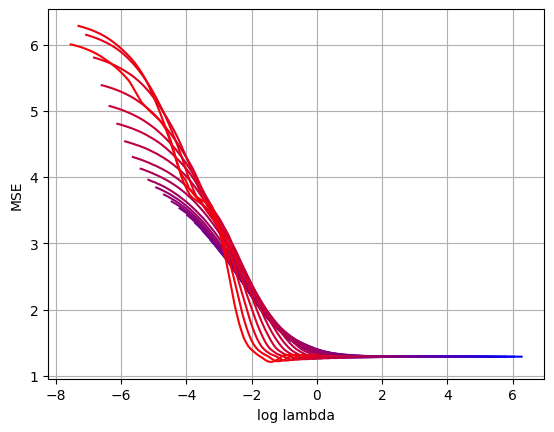

0.24586753700513397
1.0
Index(['EG.USE.COMM.GD.PP.KD', 'EG.FEC.RNEW.ZS', 'IS.AIR.GOOD.MT.K1'], dtype='object')


In [ ]:
from sklearn.linear_model import ElasticNetCV

Nr = np.linspace(np.log(0.001), np.log(1),30)

elnet_adv = ElasticNetCV(fit_intercept = True, max_iter = 10000, cv = X_train.shape[0],
                         l1_ratio=np.exp(Nr))
elnet_adv.fit(X=X_train,y=y_train)

for j in range(0,len(Nr)):
  plt.plot(np.log(elnet_adv.alphas_[j]), elnet_adv.mse_path_[j].mean(axis=1),c=(j/len(Nr),0,1-j/len(Nr)))

plt.grid()
plt.xlabel("log lambda")
plt.ylabel("MSE")
plt.show()

print(elnet_adv.alpha_)
print(elnet_adv.l1_ratio_)
print(X_train.columns[np.abs(elnet_adv.coef_) > 0])

The fitted ElasticNet model chooses a full LASSO penalty term (l1 ratio = 1) with a lambda of 0.25. Unsurprisingly, this model selects the same predictors as the previous LASSO model. In other words, allowing for a RIDGE penalty term does not afford better prediction.

### K-Nearest Neighbours model

Setting up the model and tuning its parameter.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

kN = np.arange(1,X_train.shape[0])

kNN_class = KNeighborsRegressor()
parameters = {'n_neighbors': kN}
kNNCV = GridSearchCV(kNN_class, parameters, cv=X_train.shape[0], verbose=1,
                       return_train_score=True, scoring='neg_mean_squared_error')

kNNCV.fit(X_train, y_train)

Fitting 22 folds for each of 21 candidates, totalling 462 fits


GridSearchCV(cv=22, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

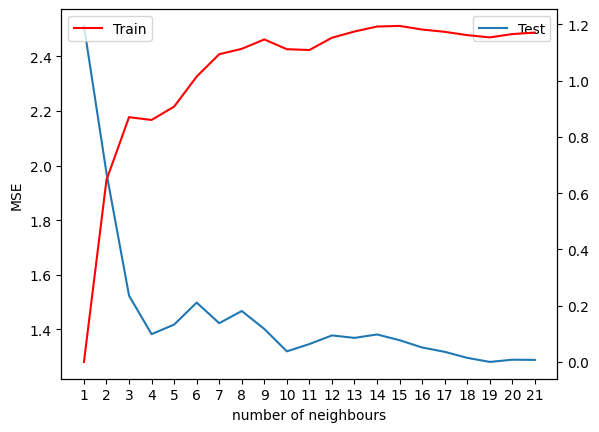

In [ ]:
cv_kNN_results = pd.DataFrame(kNNCV.cv_results_)
# Plotting
fig, ax = plt.subplots()
ax.plot(kN, -cv_kNN_results.mean_test_score, label="Test")
ax.set_xlabel('number of neighbours')
ax.set_ylabel('MSE')
ax.legend(loc="upper right")
ax1 = ax.twinx()
ax1.plot(kN, -cv_kNN_results.mean_train_score,'r-', label="Train")
ax1.legend(loc="upper left")
plt.xticks(kN)
plt.show()

A kNN model with 4 neighbours seems to provide the best cross-validated fit based on the elbow criterion. I will use this model for forecasting.

In [ ]:
#fit the kNN model with 4 neighbours

kNN_best = KNeighborsRegressor(n_neighbors=4)

kNN_best.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=4)

### Random Forest regression model

Setting up the model, tuning its parameters (only one for simplicity) and looking at the important features for prediction.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

max_features = np.arange(1,df_world_tf.shape[1],3) # for simplicity, I will only tune the feature split parameter

np.random.seed(31415) # impose random seed for reproducibility

forest = RandomForestRegressor(n_estimators=200)
parameters = {'max_features': max_features}
rfCV = GridSearchCV(forest, parameters, cv=X_train.shape[0], verbose=1,
                       return_train_score=True, refit=True, scoring='neg_mean_squared_error')

rfCV.fit(X_train, y_train)

Fitting 22 folds for each of 15 candidates, totalling 330 fits


GridSearchCV(cv=22, estimator=RandomForestRegressor(n_estimators=200),
             param_grid={'max_features': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

1


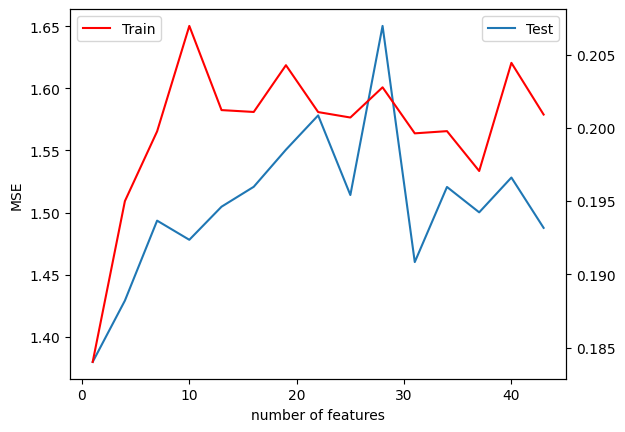

In [ ]:
print(rfCV.best_estimator_.max_features)

cv_results = pd.DataFrame(rfCV.cv_results_)
# Plotting
fig, ax = plt.subplots()
ax.plot(max_features, -cv_results.mean_test_score, label='Test')
ax.set_xlabel('number of features')
ax.set_ylabel('MSE')
ax.legend(loc="upper right")
ax1 = ax.twinx()
ax1.plot(max_features, -cv_results.mean_train_score, 'r-', label='Train')
ax1.legend(loc="upper left")
plt.show()

In [ ]:
importance = rfCV.best_estimator_.feature_importances_
features = X_train.columns
important_features = pd.Series(data=importance/importance.max(), index=features)
important_features.sort_values(ascending=False).head(20)

SP.URB.GROW             1.000000
EG.ELC.PETR.ZS          0.972130
EG.ELC.RNWX.ZS          0.955892
EG.USE.COMM.GD.PP.KD    0.931985
SH.DYN.MORT             0.899546
IT.CEL.SETS             0.877040
EG.ELC.RNWX.KH          0.862113
BX.GSR.CCIS.ZS          0.827867
SP.POP.TOTL             0.825239
EG.USE.ELEC.KH.PC       0.822630
SP.POP.GROW             0.820834
EG.USE.PCAP.KG.OE       0.814857
EN.URB.MCTY.TL.ZS       0.803568
EG.FEC.RNEW.ZS          0.794369
IS.AIR.DPRT             0.780384
SP.URB.TOTL.IN.ZS       0.774475
ER.H2O.INTR.PC          0.770166
EN.ATM.GHGT.KT.CE       0.761661
AG.LND.FRST.K2          0.749922
EG.ELC.COAL.ZS          0.738265
dtype: float64

The random forest model with the best performance chooses from one feature at each split. Inspection of feature importance shows that the majority of features are assign equal weight so no feature seems to be particularly important in determining the split.

### Gradient Boosting regression model

Setting up the model, tuning its parameters (only one for simplicity) and looking at the important features for prediction.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

learning = np.linspace(np.log(0.001), np.log(1),30) # for simplicity, I only tune the learning rate parameter

np.random.seed(31415) # impose random seed for reproducibility

gbm = GradientBoostingRegressor(n_estimators=200)
parameters = {'learning_rate': np.exp(learning)}
gbmCV = GridSearchCV(gbm, parameters, cv=15, verbose=1,
                       return_train_score=True, refit=True, scoring='neg_mean_squared_error')

gbmCV.fit(X_train, y_train)

Fitting 15 folds for each of 30 candidates, totalling 450 fits


GridSearchCV(cv=15, estimator=GradientBoostingRegressor(n_estimators=200),
             param_grid={'learning_rate': array([0.001     , 0.00126896, 0.00161026, 0.00204336, 0.00259294,
       0.00329034, 0.00417532, 0.00529832, 0.00672336, 0.00853168,
       0.01082637, 0.01373824, 0.01743329, 0.02212216, 0.02807216,
       0.03562248, 0.04520354, 0.05736153, 0.07278954, 0.09236709,
       0.11721023, 0.14873521, 0.18873918, 0.23950266, 0.30391954,
       0.38566204, 0.48939009, 0.62101694, 0.78804628, 1.        ])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

0.0012689610031679226


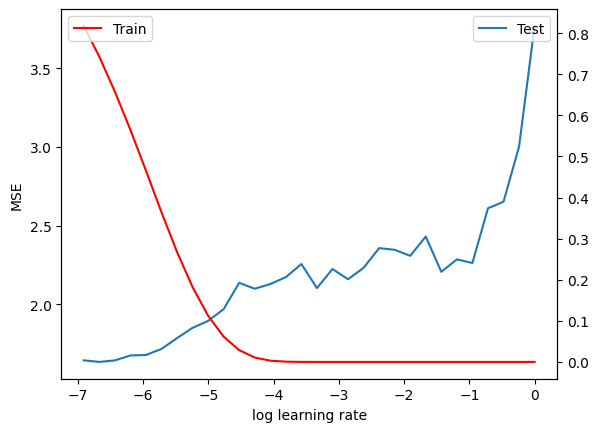

In [ ]:
print(gbmCV.best_estimator_.learning_rate)

cv_gbm_results = pd.DataFrame(gbmCV.cv_results_)
# Plotting
fig, ax = plt.subplots()
ax.plot(learning, -cv_gbm_results.mean_test_score, label='Test')
ax.set_xlabel('log learning rate')
ax.set_ylabel('MSE')
ax.legend(loc="upper right")
ax1 = ax.twinx()
ax1.plot(learning, -cv_gbm_results.mean_train_score, 'r-', label='Train')
ax1.legend(loc="upper left")
plt.show()

In [ ]:
importance = gbmCV.best_estimator_.feature_importances_
features = X_train.columns
important_features = pd.Series(data=importance/importance.max(), index=features)
important_features.sort_values(ascending=False).head(10)

IS.AIR.GOOD.MT.K1    1.000000
SP.POP.TOTL          0.324842
SP.URB.TOTL.IN.ZS    0.117594
EG.ELC.RNWX.KH       0.067099
EG.ELC.NUCL.ZS       0.012047
BX.GSR.CCIS.ZS       0.011290
SP.POP.GROW          0.010609
AG.LND.AGRI.ZS       0.009543
SP.URB.TOTL          0.009351
SI.POV.DDAY          0.008589
dtype: float64

The gradient boost model with the best performance has a learning rate of 0.001. Inspection of feature importance shows that most weight is assigned to the freight air transport indicator also identified in the linear models.

### Comparing forecast performance

Finally, I compare how well each model forecasts total greenhouse gas emissions out-of-sample for the time period between 2016 and 2019. As a criterion I use the mean squared prediction error.

In [ ]:
# forecast predicitons variables
forecasts = pd.DataFrame(index=y_test.index)
forecast_err = pd.DataFrame(index=y_test.index)

# Out of sample forecast
forecasts['naive'] = naive_forecaster(y_train)
forecast_err['naive'] = (y_test - forecasts['naive'])**2

forecasts['Full'] = full_model(y_train, X_train, X_test)
forecast_err['Full'] = ( y_test - forecasts['Full'])**2

forecasts['LASSO'] = lasso.predict( X_test )
forecast_err['LASSO'] = ( y_test - forecasts['LASSO'])**2

forecasts['ElNetAdv'] = elnet_adv.predict( X_test )
forecast_err['ElNetAdv'] = ( y_test - forecasts['ElNetAdv'])**2

forecasts['kNN'] = kNN_best.predict( X_test )
forecast_err['kNN'] = ( y_test - forecasts['kNN'])**2

forecasts['RF'] = rfCV.best_estimator_.predict(X_test)
forecast_err['RF'] = (y_test - forecasts['RF'])**2
np.sqrt( forecast_err.RF.mean() )

forecasts['GB'] = gbmCV.best_estimator_.predict(X_test)
forecast_err['GB'] = (y_test - forecasts['GB'])**2

# show MSE for each model
MSE =  pd.DataFrame(forecast_err.mean(axis=0), columns=['MSE']).transpose()
MSE

,naive,Full,LASSO,ElNetAdv,kNN,RF,GB
MSE,0.4371,1.094489,0.336047,0.336757,0.671468,0.513157,0.588132


Let's plot the forecasted total greenhouse gas emissions by each model.

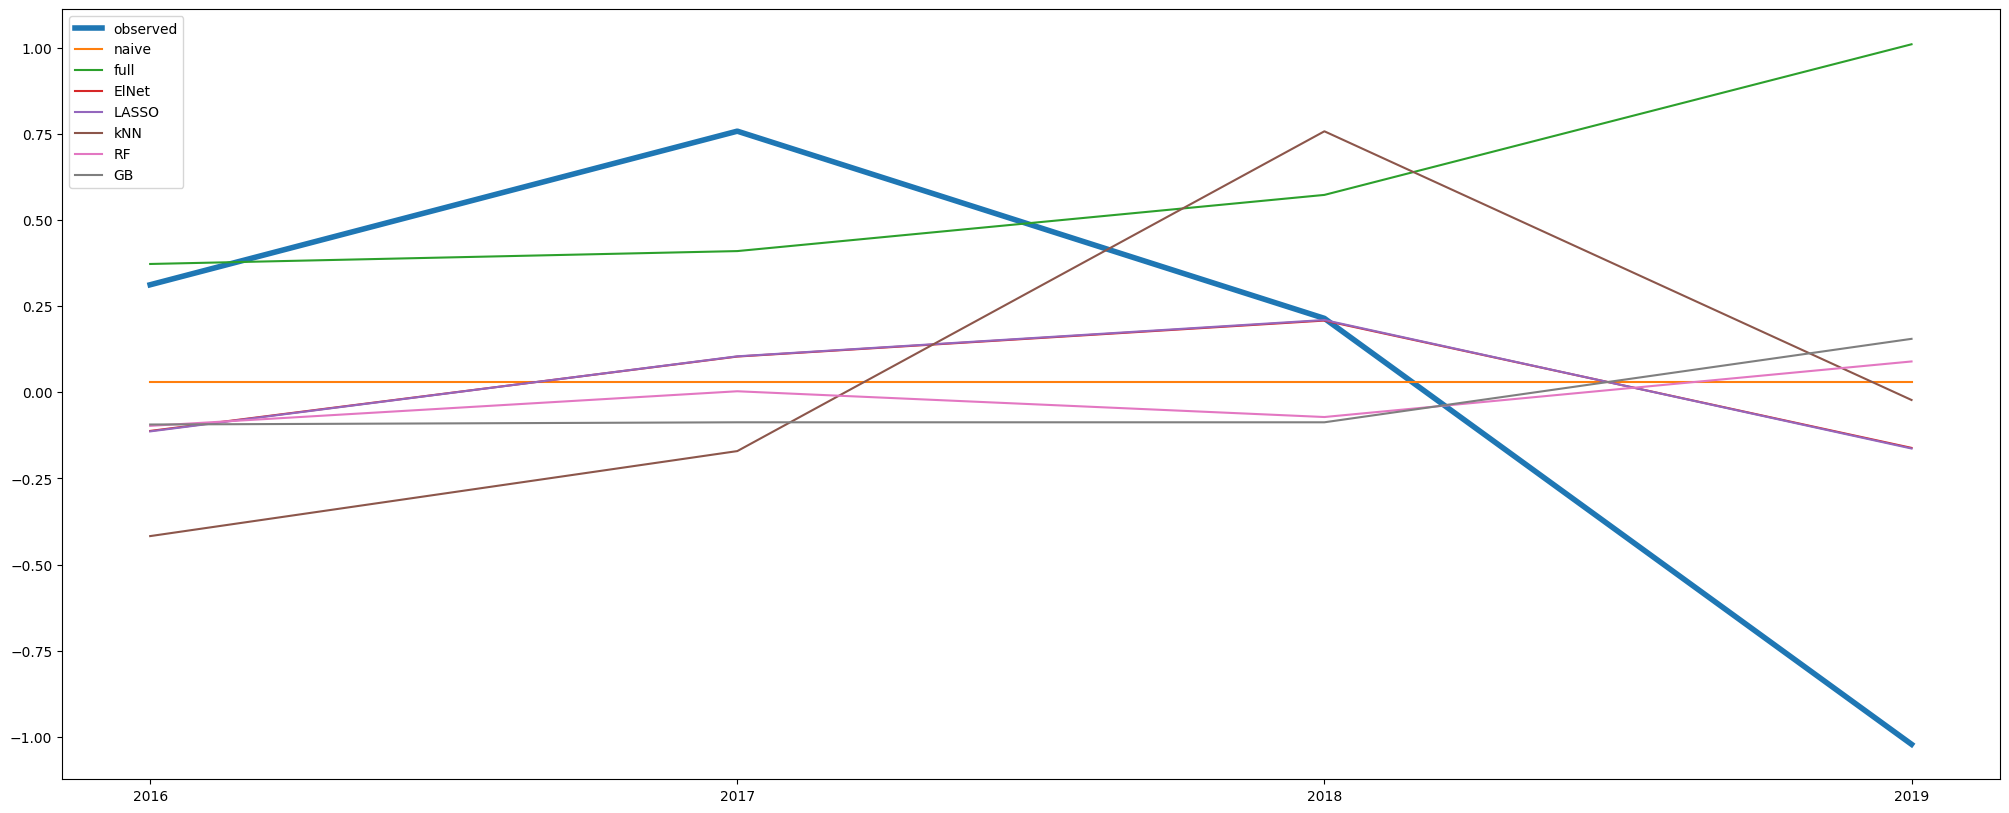

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(25,10))

ax1.plot(y_test,label="observed",linewidth=4)
ax1.plot(forecasts.naive,label="naive")
ax1.plot(forecasts.Full,label="full")
ax1.plot(forecasts.ElNetAdv,label="ElNet") # note that the ELNET prediction is obscured by the LASSO prediction
ax1.plot(forecasts.LASSO,label="LASSO")
ax1.plot(forecasts.kNN,label="kNN")
ax1.plot(forecasts.RF,label="RF")
ax1.plot(forecasts.GB,label="GB")
ax1.legend()

plt.show()

The LASSO model yields the best prediction accuracy showing the smallest MSE out-of-sample. This suggests that the three features energy use per $1,000 GDP, renewable energy consumption, and freight air transport are most important in forecasting world-wide greenhouse gas emissions. The Elastic Net model performs almost identically to the LASSO which is unsurprising since the best model chooses a full LASSO penalty term. Note, however, that the fitted lambda parameter only marginally improves cross-validated accuracy compared to higher values for lambda (see the shallow tail in the tuning plot for the LASSO model). A less complex model that sets all coefficients to zero should therefore yield very similar performance (i.e., prediction only based on feature intercepts/means).

The non-linear models perform surprisingly poorly not even reaching accuracy levels of the naive forecaster model, which only bases its prediction on average greenhouse gas emissions in the training set. Note, however, that performance is still much better than the full model. The non-linear models seem to struggle when there is little predictive power in the features.

### Generalizability of forecast performance

The previous approach to evaluate forecast performance has one substantial shortcoming: Since the time-series is only split once to define training and test sets, forecasts in the more distant future do not leverage potentially relevant feature information from the more recent past. This could possibly explain the limited forecast performance of our models in the previous analysis. To address this issue, I will employ a version of a [rolling forecast origin](https://otexts.com/fpp3/tscv.html) cross-validation method. Specifically, I will iteratively increase the size of the training dataset by one datapoint and evaluate forecast performance only on the immediately subsequent timepoint (see also [this paper](https://doi.org/10.1016/j.ins.2011.12.028) describing this nested cross-validation approach). This method should leverage more information for model training, provide a more generalizable measure of forecast performance, and resemble a more realistic scenario where new data is streaming in over time.

In [14]:
# years to define train-test splits in each iteration
test_years = ['2007','2008','2009','2010','2011','2012','2013','2014', '2015', '2016', '2017', '2018']

def get_forecast_years(year):
    return str(int(year)+1)

forecast_years = list(map(get_forecast_years,test_years))

# initialize df for model forecast evaluation
forecasts = pd.DataFrame()
forecast_err = pd.DataFrame()

In [16]:
# define models

# naive
def naive_forecaster(y_train):
  return np.mean(y_train)

# full
from sklearn.linear_model import LinearRegression

def full_model(y_train, x_train, x_test):
  reg  = LinearRegression( fit_intercept=True ) # We create an instance of the linear regression class.
  reg.fit( X = x_train, y = y_train )
  return reg.predict(x_test)

# lasso
from sklearn.linear_model import LassoCV

lasso = LassoCV(fit_intercept = True, max_iter=1000000, alphas = np.exp(np.linspace(np.log(0.001), np.log(10),1000)))

# elnet
from sklearn.linear_model import ElasticNetCV

Nr = np.linspace(np.log(0.001), np.log(1),30)
elnet_adv = ElasticNetCV(fit_intercept = True, max_iter = 10000,
                         l1_ratio=np.exp(Nr))

# kNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

kNN_class = KNeighborsRegressor()
kNNCV = GridSearchCV(kNN_class, {}, verbose=1,
                       return_train_score=True, scoring='neg_mean_squared_error')

# RF
from sklearn.ensemble import RandomForestRegressor

max_features = np.arange(1,df_world_tf.shape[1],3) # for simplicity, I will only tune the feature split parameter
np.random.seed(31415) # impose random seed for reproducibility
forest = RandomForestRegressor(n_estimators=200)
parameters = {'max_features': max_features}
rfCV = GridSearchCV(forest, parameters, verbose=1,
                       return_train_score=True, refit=True, scoring='neg_mean_squared_error')

# GB
from sklearn.ensemble import GradientBoostingRegressor

learning = np.linspace(np.log(0.001), np.log(1),30) # for simplicity, I only tune the learning rate parameter
np.random.seed(31415) # impose random seed for reproducibility
gbm = GradientBoostingRegressor(n_estimators=200)
parameters = {'learning_rate': np.exp(learning)}
gbmCV = GridSearchCV(gbm, parameters, cv=15, verbose=1,
                       return_train_score=True, refit=True, scoring='neg_mean_squared_error')

In [20]:
# iterate over train-test splits, fit models, and evaluate forecast performance

for split_year in test_years:

  # define train and test data
  idx = df_world_tf.index.get_loc(split_year)
  dt_train = df_world_tf.iloc[:idx+1,:]
  dt_test  = df_world_tf.iloc[idx:idx+2,:]

  # forecast t+1
  y_train = dt_train["EN.ATM.GHGT.KT.CE"][1:]
  X_train = dt_train.iloc[:-1,:]

  y_test = dt_test["EN.ATM.GHGT.KT.CE"][1:]
  X_test = dt_test.iloc[:-1,:]

  print('Training on ' + X_train.index[0] + ' to ' + X_train.index[-1])
  print('Forecast from ' + X_test.index[0] + ' for ' + y_test.index[0])

  # --- train models and collect forecast errors ---
  # naive
  y_hat_test = naive_forecaster(y_train) # collect forecasts
  forecasts.loc[y_test.index[-1],'naive'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'naive'] = (y_test[-1] - y_hat_test)**2

  # full
  y_hat_test = full_model(y_train, X_train, X_test) # collect forecasts
  forecasts.loc[y_test.index[-1],'full_model'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'full_model'] = (y_test[-1] - y_hat_test)**2

  # lasso
  lasso.cv = X_train.shape[0]
  lasso.fit(X=X_train, y=y_train)

  y_hat_test = lasso.predict(X_test) # collect forecasts
  forecasts.loc[y_test.index[-1],'LASSO'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'LASSO'] = (y_test[-1] - y_hat_test)**2

  # elnet
  elnet_adv.cv = X_train.shape[0]
  elnet_adv.fit(X=X_train,y=y_train)

  y_hat_test = elnet_adv.predict(X_test) # collect forecasts
  forecasts.loc[y_test.index[-1],'ElNetAdv'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'ElNetAdv'] = (y_test[-1] - y_hat_test)**2

  # kNN
  kN = np.arange(1,X_train.shape[0])
  parameters = {'n_neighbors': kN}
  kNNCV.param_grid = parameters
  kNNCV.cv = X_train.shape[0]
  kNNCV.fit(X_train, y_train)

  y_hat_test = kNNCV.best_estimator_.predict(X_test) # collect forecasts
  forecasts.loc[y_test.index[-1],'kNN'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'kNN'] = (y_test[-1] - y_hat_test)**2

  # RF
  rfCV.cv = X_train.shape[0]
  rfCV.fit(X_train, y_train)

  y_hat_test = rfCV.best_estimator_.predict(X_test) # collect forecasts
  forecasts.loc[y_test.index[-1],'RF'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'RF'] = (y_test[-1] - y_hat_test)**2

  # GB
  gbmCV.fit(X_train, y_train)

  y_hat_test = gbmCV.best_estimator_.predict(X_test)  # collect forecasts
  forecasts.loc[y_test.index[-1],'GB'] = (y_hat_test)
  forecast_err.loc[y_test.index[-1],'GB'] = (y_test[-1] - y_hat_test)**2

Training on 1992 to 2006
Forecast from 2007 for 2008
Fitting 15 folds for each of 14 candidates, totalling 210 fits
Fitting 15 folds for each of 15 candidates, totalling 225 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Training on 1992 to 2007
Forecast from 2008 for 2009
Fitting 16 folds for each of 15 candidates, totalling 240 fits
Fitting 16 folds for each of 15 candidates, totalling 240 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Training on 1992 to 2008
Forecast from 2009 for 2010
Fitting 17 folds for each of 16 candidates, totalling 272 fits
Fitting 17 folds for each of 15 candidates, totalling 255 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Training on 1992 to 2009
Forecast from 2010 for 2011
Fitting 18 folds for each of 17 candidates, totalling 306 fits
Fitting 18 folds for each of 15 candidates, totalling 270 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Training on 1992 to 2010
Forecas

In [23]:
# show MSE for each model
MSE =  pd.DataFrame(forecast_err.mean(axis=0), columns=['MSE']).transpose()
MSE

,naive,LASSO,ElNetAdv,kNN,RF,GB,full_model
MSE,1.930034,1.994809,1.952902,1.939816,2.147986,2.176374,3.491418


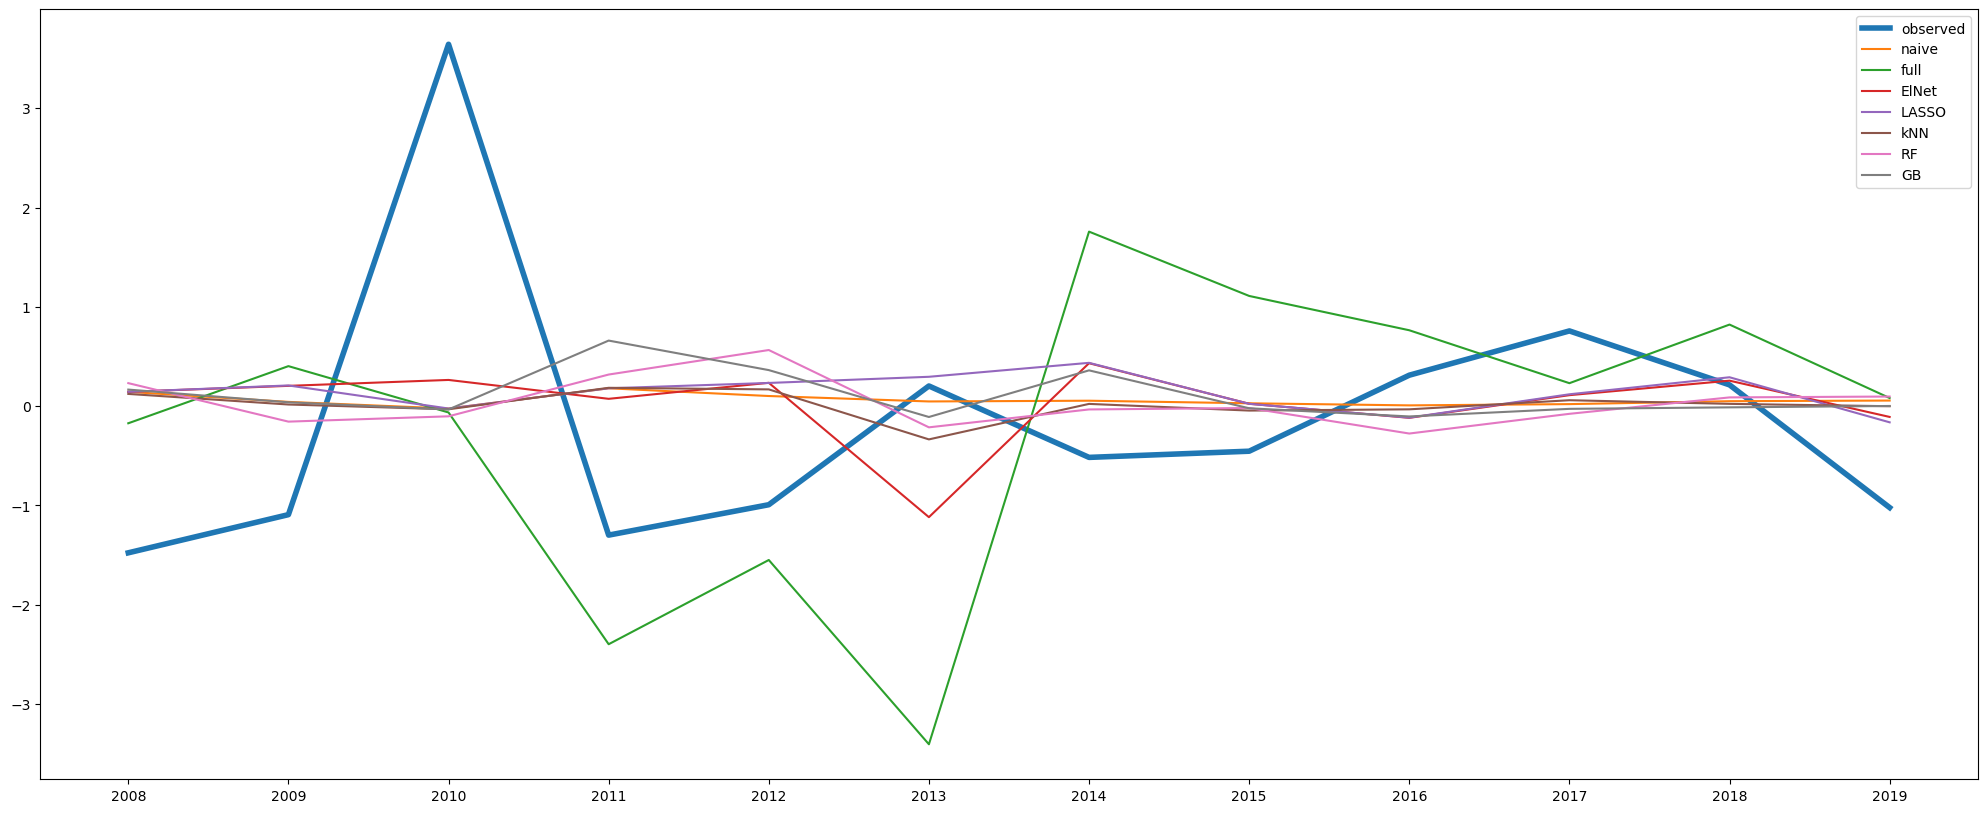

In [24]:
fig, ax1 = plt.subplots(1,1,figsize=(25,10))

ax1.plot(df_world_tf.loc[forecast_years,"EN.ATM.GHGT.KT.CE"],label="observed",linewidth=4)
ax1.plot(forecasts.naive,label="naive")
ax1.plot(forecasts.full_model,label="full")
ax1.plot(forecasts.ElNetAdv,label="ElNet")
ax1.plot(forecasts.LASSO,label="LASSO")
ax1.plot(forecasts.kNN,label="kNN")
ax1.plot(forecasts.RF,label="RF")
ax1.plot(forecasts.GB,label="GB")
ax1.legend()

plt.show()

We see that none of our models outperforms the naive baseline benchmark (ie., a model that only relies on historic average total greenhouse gas emissions). Maybe tuning the parameters more would yield somewhat better results but it seems unlikely. Instead, the poor forecast performance of the tested models likely results from data scarcity, which is a limitation of this dataset. More data would likely increase robustness of the fitted models possibly affording better forecast performance.